In [1]:
import numpy as np


In [2]:
from scipy.sparse import diags, eye, kron
def tridiag(a, b, c, n):
    # Create a tridiagonal matrix
    return diags([a*np.ones(n-1), b*np.ones(n), c*np.ones(n-1)], [-1, 0, 1], format='csr')

def fd3d(nx, ny, nz, alpx, alpy, alpz, dshift):
    # Create tridiagonal matrices tx, ty, tz
    tx = tridiag(-1+alpx, 2, -1-alpx, nx)
    ty = tridiag(-1+alpy, 2, -1-alpy, ny)
    tz = tridiag(-1+alpz, 2, -1-alpz, nz)

    # Compute A using Kronecker products
    A = kron(eye(ny), tx) + kron(ty, eye(nx))
    if nz > 1:
        A = kron(eye(nz), A) + kron(tz, eye(nx*ny))

    # Subtract dshift times identity matrix from A
    A -= dshift * eye(nx*ny*nz)

    return A.tocsr()

In [3]:
def steep(A, b, x, nsteps, tol=1.e-08):
    """
    Steepest descent algorithm for solving Ax = b.

    Parameters:
        A : numpy.ndarray
            Symmetric positive definite matrix.
        b : numpy.ndarray
            Right-hand side vector.
        x : numpy.ndarray
            Initial guess for the solution.
        nsteps : int
            Maximum number of iterations.
        tol : float, optional
            Tolerance for convergence. Default is 1.e-08.

    Returns:
        x : numpy.ndarray
            Approximate solution vector.
        nrmHist : list
            History of norms for convergence analysis.
    """
    r = b - A @ x
    ro = np.linalg.norm(r)
    nrmHist = [ro]
    tol_rel = tol * ro

    for i in range(nsteps):
        ar = A @ r
        alp = r.T @ r / (r.T @ ar)
        x = x + alp * r
        r = r - alp * ar
        ro = np.linalg.norm(r)

        nrmHist.append(ro)
        if ro < tol_rel:
            break

    return x, nrmHist

In [4]:
def mr(A, b, x, nsteps, tol=None):
    """
    Minimal residual method for solving Ax = b.

    Parameters:
        A : numpy.ndarray
            Matrix representing the linear system.
        b : numpy.ndarray
            Right-hand side vector.
        x : numpy.ndarray
            Initial guess for the solution.
        nsteps : int
            Maximum number of iterations.
        tol : float, optional
            Tolerance for convergence. If not specified, uses machine epsilon.

    Returns:
        x : numpy.ndarray
            Approximate solution vector.
        nrmHist : list
            History of norms for convergence analysis.
    """
    r = b - A @ x
    ro = np.linalg.norm(r)
    nrmHist = [ro]
    if tol is None:
        tol = np.finfo(float).eps
    tol_rel = tol * ro

    for i in range(nsteps):
        ar = A @ r
        alp = (ar.T @ r) / (ar.T @ ar)
        x = x + alp * r
        r = r - alp * ar
        ro = np.linalg.norm(r)

        nrmHist.append(ro)
        if ro < tol_rel:
            break

    return x, nrmHist


In [5]:
def rnsteep(A, b, x, nsteps, tol=None):
    """
    Residual Norm Steepest Descent method for solving Ax = b.

    Parameters:
        A : numpy.ndarray
            Coefficient matrix.
        b : numpy.ndarray
            Right-hand side vector.
        x : numpy.ndarray
            Initial guess for the solution.
        nsteps : int
            Maximum number of iterations.
        tol : float, optional
            Tolerance for convergence. If not specified, uses machine epsilon.

    Returns:
        x : numpy.ndarray
            Approximate solution vector.
        nrmHist : list
            History of norms for convergence analysis.
    """
    r = b - A @ x
    ro = np.linalg.norm(r)
    nrmHist = [ro]
    if tol is None:
        tol = np.finfo(float).eps
    tol_rel = tol * ro

    for i in range(nsteps):
        d = A.T @ r
        Ad = A @ d
        alp = (d.T @ d) / (Ad.T @ Ad)
        x = x + alp * d
        r = r - alp * Ad
        ro = np.linalg.norm(r)

        nrmHist.append(ro)
        if ro < tol_rel:
            break

    return x, nrmHist


In [6]:
import numpy as np
from scipy.sparse import csr_matrix, tril, triu
from scipy.sparse.linalg import spsolve

def sor(A, b, x, max_iterations=1000,omega=1.1, tolerance=1e-10):
    if not 0 < omega < 2:
        raise ValueError("Omega must be between 0 and 2 for convergence for SPD matrices.")

    n = A.shape[0]

    # Decompose A into its lower (L), diagonal (D), and upper (U) components
    D = diags(A.diagonal(), 0, format='csr')
    E = tril(A, k=-1)
    F = triu(A, k=1)

    convergence = []
    for iteration in range(max_iterations):
        x_old = x.copy()
        x = spsolve(D+omega*E, omega*b + (1-omega)*D@x_old - omega*F@x_old, use_umfpack=True)

        # Check for convergence
        convergence.append(np.linalg.norm(A.dot(x) - b, ord=np.inf))
        if np.linalg.norm(x - x_old, ord=np.inf) < tolerance:
            break

    return x, convergence

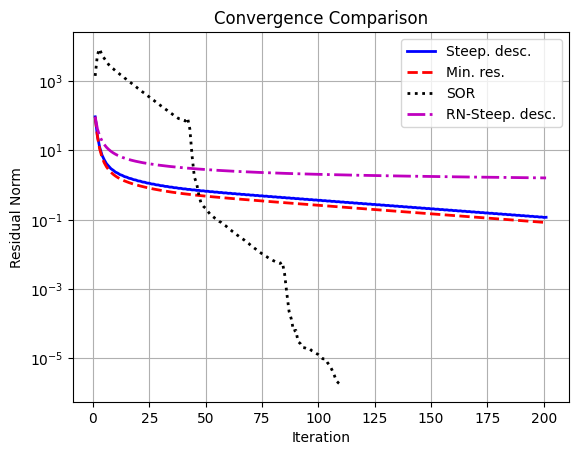

In [7]:
import numpy as np
import matplotlib.pyplot as plt


n = 20
A = fd3d(n, n, 1, 0, 0, 0, 0)
b = A @ np.ones((n*n, 1))
x = np.random.randn(n*n, 1)
nits = 200
tol = 1.e-06

# Replace steep, mr, rnsteep with the Python functions implemented as per previous instructions
x1, r1 = steep(A, b, x, nits, tol)
x2, r2 = mr(A, b, x, nits, tol)
x3, r3 = sor(A, b, x, nits, 1.8, tol)
x4, r4 = rnsteep(A, b, x, nits, tol)

# Plotting
plt.semilogy(range(1, len(r1) + 1), r1, 'b-', linewidth=2, label='Steep. desc.')
plt.semilogy(range(1, len(r2) + 1), r2, 'r--', linewidth=2, label='Min. res.')
plt.semilogy(range(1, len(r3) + 1), r3, 'k:', linewidth=2, label='SOR')
plt.semilogy(range(1, len(r4) + 1), r4, 'm-.', linewidth=2, label='RN-Steep. desc.')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('Convergence Comparison')
plt.grid(True)
plt.show()


In [8]:
import numpy as np

def cg(A, b, x0=None, max_iterations=1000, tol=1e-10):
    if x0 is None:
        x = np.zeros_like(b)
    else:
        x = x0

    r = b - A @ x
    p = r.copy()
    rsold = (r.T @ r).item()  # Ensure scalar value
    residual_norms = [np.sqrt(rsold)]

    for i in range(max_iterations):
        Ap = A @ p
        alpha = rsold / (p.T @ Ap).item()  # Ensure scalar value
        x = x + alpha * p
        r = r - alpha * Ap
        rsnew = (r.T @ r).item()  # Ensure scalar value
        residual_norms.append(np.sqrt(rsnew))

        if residual_norms[-1] < tol:
            break

        p = r + (rsnew / rsold) * p
        rsold = rsnew

    return x, np.array(residual_norms)  # Convert to NumPy array for consistent handling



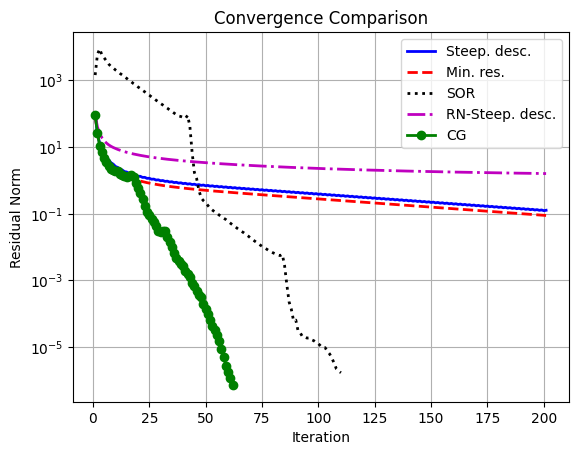

In [9]:
import numpy as np
import matplotlib.pyplot as plt


n = 20
A = fd3d(n, n, 1, 0, 0, 0, 0)
b = A @ np.ones((n*n, 1))
x = np.random.randn(n*n, 1)
nits = 200
tol = 1.e-06

# Replace steep, mr, rnsteep with the Python functions implemented as per previous instructions
x1, r1 = steep(A, b, x, nits, tol)
x2, r2 = mr(A, b, x, nits, tol)
x3, r3 = sor(A, b, x, nits, 1.8, tol)
x4, r4 = rnsteep(A, b, x, nits, tol)
x5, r5 = cg(A, b, x, nits, tol)

# Plotting
plt.semilogy(range(1, len(r1) + 1), r1, 'b-', linewidth=2, label='Steep. desc.')
plt.semilogy(range(1, len(r2) + 1), r2, 'r--', linewidth=2, label='Min. res.')
plt.semilogy(range(1, len(r3) + 1), r3, 'k:', linewidth=2, label='SOR')
plt.semilogy(range(1, len(r4) + 1), r4, 'm-.', linewidth=2, label='RN-Steep. desc.')
plt.semilogy(range(1, len(r5) + 1), r5, 'g-o', linewidth=2, label='CG')

plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Residual Norm')
plt.title('Convergence Comparison')
plt.grid(True)
plt.show()